In [145]:
import json 
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.patches as pt 
from pandas.io.json import json_normalize #package for flattening json in pandas df



#drawing footbal field

def draw_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = pt.Rectangle([0,0], width = 120, height = 80, fill = False)
    #Left, Right Penalty Area and midline
    LeftPenalty = pt.Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False)
    RightPenalty = pt.Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)
    midline = pt.ConnectionPatch([60,0], [60,80], "data", "data")

    #Left, Right 6-yard Box
    LeftSixYard = pt.Rectangle([0,32], width = 4.9, height = 16, fill = False)
    RightSixYard = pt.Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    leftArc = pt.Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = pt.Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
    element = [Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

        


In [146]:
#open matches_Italy.json in a dataframe and filter with match: Juventus-Napoli 0-1

with open('/Users/digitalfirst/Desktop/homework_dataFrame/matches/matches_Italy.json') as f:
    teams = json.load(f)
df_teams = json_normalize(teams)

match=df_teams.loc[df_teams['label']=="Juventus - Napoli, 0 - 1"]
match_Id=match['wyId']


In [147]:
#open events_Italy.json in a dataframe and filtered data only for pass event. We get only some atttributes
with open('/Users/digitalfirst/Desktop/homework_dataFrame/events/events_Italy.json') as f:
    d = json.load(f)

df_events = json_normalize(data=d, record_path=['positions'],
                            meta=['subEventName', 'eventName','playerId','eventSec','matchId',"subEventId"])
df_events = df_events.loc[(df_events['eventName']=='Pass')]



In [148]:
#get id for every passes and merge it with last dataframe. Now we have every pass with tags that say us the status of respective event
df_events_tags = json_normalize(data=d, record_path=['tags'],
                            meta=['eventName','eventSec'])
df_events_tags = df_events_tags.loc[(df_events_tags['eventName']=='Pass')]
df_events_tags=df_events_tags[['id','eventSec']]


In [149]:
allPasses = pd.merge(match,df_events,left_on='wyId', right_on='matchId')
allPasses=allPasses[['subEventName', 'eventName','playerId','eventSec','matchId','x','y','label', "subEventId"]]


In [150]:
#open players.json and put data about Jorginho and pjanic in two different dataframes

with open('/Users/digitalfirst/Desktop/homework_dataFrame/players.json') as f:
    d = json.load(f)
players = json_normalize(d)
jorginho=players.loc[players['shortName']=="Jorginho"]
pjanic=players.loc[players['firstName']=="Miralem"]


In [151]:
#merge pjanic dataframe with all passes dataframe and get from it only some attributes
allPasses_pjanic = pd.merge(allPasses,pjanic,left_on='playerId', right_on='wyId')
allPasses_pjanic=allPasses_pjanic[['subEventName', 'eventName','playerId','eventSec','matchId','x','y','label','shortName']]
#merge jorginho dataframe with all passes dataframe and get it only for some attributes
allPasses_jorginho = pd.merge(allPasses,jorginho,left_on='playerId', right_on='wyId')
allPasses_jorginho=allPasses_jorginho[['subEventName', 'eventName','playerId','eventSec','matchId','x','y','label','shortName',"subEventId"]]

#sort both dataframes about index. in this way we have a list of event for jorginho and pjanic. for every event we have tow rows, the first that have the coordinates that indicate the started position of the event, and the second row stay for the final position of respective event.
allPasses_pjanic=allPasses_pjanic.sort_index()
allPasses_jorginho=allPasses_jorginho.sort_index()


In [152]:
def draw_HeatMap_PassMap(allPasses):
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 5)
    i=0
    x_coord = []
    y_coord = []

    #remember that every pass refer two consecutive rows in dataframe (first row about start position and second row about final position)
    while (i<len(allPasses)):
        #draw arrows for every pass and resize every cooridnate for every pass in footbal field dimension
        ax.annotate("", xy = ((allPasses.iloc[i+1]['x']*120)/100, (allPasses.iloc[i+1]['y']*80)/100), xycoords = 'data', xytext = ((allPasses.iloc[i]['x']*120)/100, (allPasses.iloc[i]['y']*80)/100), textcoords = 'data', arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)

        #x and y are coodinates that indicate the start position for every pass. These info are used for heatMap
        x_coord.append((allPasses.iloc[i]['x']*120)/100)
        y_coord.append((allPasses.iloc[i]['y']*80)/100)
        i=i+2



    #draw heat Map on the same figure where i draw arrows
    sns.kdeplot(x_coord, y_coord, shade = "True", color = "green", n_levels = 45, shade_lowest=False)
    draw_pitch(ax) #overlay our different objects on the pitch
    plt.ylim(-2, 82)
    plt.xlim(-2, 122)

    plt.axis('off')
    plt.show()

In [153]:
#this is a function that draw pass map and heat map for wrong and right passes. Red=wrong passes; Bliue=right passes

def draw_HeatMap_PassMap2(allPassesRight, allPassesWrong):
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 5)
    i=0
    x_coord = []
    y_coord = []
    
    #remember that every pass refer two consecutive rows in dataframe (first row about start position and second row about final position)
    while (i<len(allPassesRight)):
        #draw blue arrows for every accurate pass and resize every cooridnate for every pass in footbal field dimension
        ax.annotate("", xy = ((allPassesRight.iloc[i+1]['x']*120)/100, (allPassesRight.iloc[i+1]['y']*80)/100), xycoords = 'data', xytext = ((allPassesRight.iloc[i]['x']*120)/100, (allPassesRight.iloc[i]['y']*80)/100), textcoords = 'data', arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)
        
                #x and y are coodinates that indicate the start position for every pass. These info are used for heatMap
        x_coord.append((allPassesRight.iloc[i]['x']*120)/100)
        y_coord.append((allPassesRight.iloc[i]['y']*80)/100)
        i=i+2
    j=0  
    while (j<len(allPassesWrong)):
        #draw red arrows for every not accurate pass and resize every cooridnate for every pass in footbal field dimension
        ax.annotate("", xy = ((allPassesWrong.iloc[j+1]['x']*120)/100, (allPassesWrong.iloc[j+1]['y']*80)/100), xycoords = 'data', xytext = ((allPassesWrong.iloc[j]['x']*120)/100, (allPassesWrong.iloc[j]['y']*80)/100), textcoords = 'data', arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"),)
        #x and y are coodinates that indicate the start position for every pass. These info are used for heatMap
        x_coord.append((allPassesWrong.iloc[j]['x']*120)/100)
        y_coord.append((allPassesWrong.iloc[j]['y']*80)/100)
        j=j+2

    #draw heat Map on the same figure where i draw arrows
    sns.kdeplot(x_coord, y_coord, shade = "False", color = "green", n_levels = 45, shade_lowest=False)
    draw_pitch(ax) #overlay our different objects on the pitch
    plt.ylim(-2, 82)
    plt.xlim(-2, 122)

    plt.axis('off')
    plt.show()

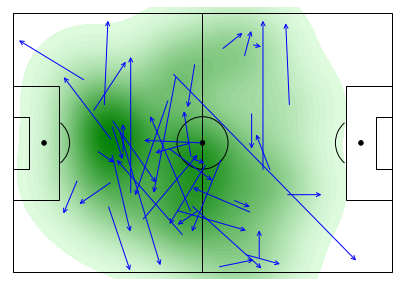

In [154]:
#draw passMap about all Pjanic passes
draw_HeatMap_PassMap(allPasses_pjanic)

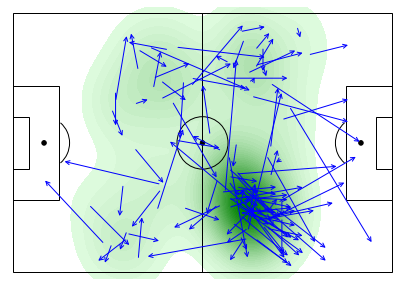

In [155]:
#draw passMap about all Jorginho passes
draw_HeatMap_PassMap(allPasses_jorginho)

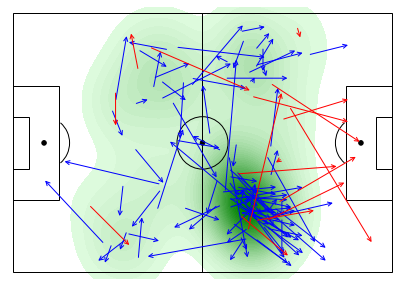

In [156]:
#I put in 'allPasses_right_jorginho' dataframe all Jorginho accuratee passes 
allPasses_right_jorginho = pd.merge(allPasses_jorginho,df_events_tags,left_on='eventSec', right_on='eventSec')
allPasses_right_jorginho=allPasses_right_jorginho.loc[(allPasses_right_jorginho['id']==1801)]
allPasses_right_jorginho

#I put in 'allPasses_wrong_jorginho' dataframe all Jorginho not accuratee passes 
allPasses_wrong_jorginho = pd.merge(allPasses_jorginho,df_events_tags,left_on='eventSec', right_on='eventSec')
allPasses_wrong_jorginho=allPasses_wrong_jorginho.loc[(allPasses_wrong_jorginho['id']==1802)]
allPasses_wrong_jorginho
draw_HeatMap_PassMap2(allPasses_right_jorginho, allPasses_wrong_jorginho)

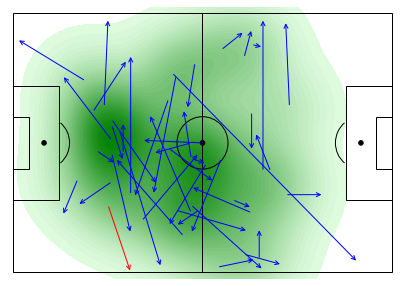

In [157]:
#i put in 'allPasses_right_pjanic' dataframe all Pjanic accuratee passes 
allPasses_right_pjanic = pd.merge(allPasses_pjanic,df_events_tags,left_on='eventSec', right_on='eventSec')
allPasses_right_pjanic=allPasses_right_pjanic.loc[(allPasses_right_pjanic['id']==1801)]
allPasses_right_pjanic

#I put in 'allPasses_wrong_pjanic' dataframe all Pjanic not accuratee passes 
allPasses_wrong_pjanic = pd.merge(allPasses_pjanic,df_events_tags,left_on='eventSec', right_on='eventSec')
allPasses_wrong_pjanic=allPasses_wrong_pjanic.loc[(allPasses_wrong_pjanic['id']==1802)]
allPasses_wrong_pjanic
draw_HeatMap_PassMap2(allPasses_right_pjanic, allPasses_wrong_pjanic)